In [1]:
import os
from pathlib import Path

import einops
import librosa
import matplotlib.pyplot as plt
# import mne
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from IPython.display import Audio, display

# from datasets import DoubleDataset
# from nn_modules import BrainModule
# from trainer import Trainer

In [ ]:
import math

import einops
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F


def cart2sph(sensor_xyz):
    x, y, z = sensor_xyz[:,0], sensor_xyz[:,1], sensor_xyz[:,2]
    xy = np.linalg.norm(sensor_xyz[:,:2], axis=-1)
    r = np.linalg.norm(sensor_xyz, axis=-1)
    theta = np.arctan2(xy, z)
    phi = np.arctan2(y, x)
    return np.stack((r, theta, phi), axis=-1)


class Spatial3DAttentionLayer(nn.Module):
    def __init__(self, n_input, n_output, K, coords_xy, n_dropout, dropout_radius, sensor_path, seed=None):
        super().__init__()

        self.n_input = n_input
        self.n_dropout = n_dropout
        self.dropout_radius = dropout_radius

        coords_xy = torch.tensor(coords_xy, dtype=torch.float32, requires_grad=False)
        self.register_buffer('_coords_xy', coords_xy)

        coords_xyz = np.load(sensor_path + 'coords/sensor_xyz.npy')
        coords_sph = cart2sph(coords_xyz)
        coords_sph = torch.tensor(coords_sph, dtype=torch.float32, requires_grad=False)

        layout = self._create_layout(coords_sph, K - 1).float()
        self.register_buffer('_layout', layout)

        Z = self._create_parameters(n_input, n_output, K, seed)
        self.Z = nn.Parameter(Z)

    def _create_layout(self, coords_sph, L=8):
        n_input = coords_sph.shape[0]

        coords_theta = coords_sph[:, 1]
        coords_phi = coords_sph[:, 2]
        layout = torch.zeros((1, L + 1, L + 1, n_input), dtype=torch.float32, requires_grad=False)

        Plak_values = np.zeros((L + 1, L + 1, n_input))
        for i in range(0, n_input):
            Plak_values[:, :, i] = scipy.special.lpmn(L, L, math.cos(coords_theta[i]))[0]
        Plak_values = torch.tensor(Plak_values, dtype=torch.float64)

        def get_factor(l, m):
            result = math.log(2 * l + 1)
            result -= math.log((2 if m == 0 else 1) * 2 * math.pi)
            result += scipy.special.gammaln(l - abs(m) + 1)
            result -= scipy.special.gammaln(l + abs(m) + 1)
            result /= 2
            result = math.exp(result)
            return result

        counter = -1
        for l in range(0, L + 1):
            for m in range(-l, l + 1):
                counter += 1
                i, j = counter % (L + 1), counter // (L + 1)
                mult_left = get_factor(l, m)
                # mult_left = 1

                if m >= 0:
                    mult = torch.cos(m * coords_phi)
                elif m < 0:
                    mult = torch.sin(- m * coords_phi)
                sela = mult_left * Plak_values[abs(m), l, :] * mult

                layout[:, i, j, :] = sela
        return layout

    def _create_parameters(self, n_input, n_output, K, seed=None):
        if seed is None:
            seed = int(torch.empty((), dtype=torch.int64).random_().item())
        generator = torch.Generator()
        generator.manual_seed(seed)

        Z = torch.randn(size=((n_output, K, K)), generator=generator) * 2 / (n_input + n_output)
        Z = einops.rearrange(Z, 'j k l -> j k l 1')
        return Z

    def to(self, device):
        self._coords_xy = self._coords_xy.to(device)
        self._layout = self._layout.to(device)
        return super().to(device)

    def get_spatial_filter(self):
        A = einops.reduce(self.Z * self._layout, 'j k l i -> j i', 'sum')
        ASoftmax = F.softmax(A, dim=1)
        return ASoftmax.clone().detach()

    def forward(self, x):
        A = einops.reduce(self.Z * self._layout, 'j k l i -> j i', 'sum')
        if self.training and self.n_dropout > 0:
            mask = torch.zeros((1, self.n_input), dtype=A.dtype, device=A.device)
            dropout_location = torch.rand(size=(self.n_dropout, 2), device=A.device) * 0.8 + 0.1
            for k in range(self.n_dropout):
                for i in range(self.n_input):
                    if torch.linalg.norm(self._coords_xy[i] - dropout_location[k]) <= self.dropout_radius:
                        mask[:, i] = - float('inf')
            A = A + mask
        ASoftmax = F.softmax(A, dim=1)
        SAx = torch.einsum('oi, bit -> bot', ASoftmax, x)
        return SAx


class SubjectPlusLayer(nn.Module):
    def __init__(self, n_input, n_output, n_subjects, regularize=True, bias=False, seed=None):
        super().__init__()
        self.bias = bias
        self.regularize = regularize
        if self.regularize:
            self.regularizer = None

        A, b = self._create_parameters(n_input, n_output, n_subjects)
        self.A = nn.Parameter(A)

        I = torch.zeros((1, n_output, n_input), requires_grad=False)
        self.register_buffer('I', I)

        if self.bias:
            self.b = nn.Parameter(b)
            zero = torch.zeros(size=(1, n_output, 1))
            self.register_buffer('zero', zero)

    def _create_parameters(self, n_input, n_output, n_subjects, seed=None):
        A = torch.zeros(size=(n_subjects, n_output, n_input))
        b = torch.zeros(size=(n_subjects, n_output, 1)) if self.bias else None
        with torch.no_grad():
            for subjects in range(n_subjects):
                layer = nn.Conv1d(in_channels=n_input, out_channels=n_output, kernel_size=1)
                A[subjects] = einops.rearrange(layer.weight.data, 'o i 1 -> o i')
                if self.bias:
                    b[subjects] = einops.rearrange(layer.bias.data, 'o -> o 1')
        return A, b

    def _create_regularizer(self, A, b):
        batch_size = A.shape[0]
        reg = torch.norm(A - self.I, p='fro')
        if self.bias:
            reg += torch.norm(b, p='fro')
        reg = reg / batch_size
        return reg

    def get_regularizer(self):
        regularizer = self.regularizer
        self.regularizer = None
        return regularizer

    def forward(self, x, s):
        batch_size = x.shape[0]

        A = torch.cat([self.I, self.A], dim=0)
        s[s >= A.size(0)] = 0
        A_ = A[s, :, :]
        out = torch.einsum('bji, bit -> bjt', A_, x)

        if self.bias:
            b = torch.cat([self.zero, self.b], dim=0)
            b_ = b[s, :, :]
            out = out + b_

        if self.regularize and self.training:
            self.regularizer = self._create_regularizer(A_, b_)

        return out


class ConvBlock(nn.Module):
    def __init__(self, n_input, n_output, block_index):
        super().__init__()

        self.kernel_size = 3
        self.block_index = block_index
        dilation1 = 2 ** (2 * block_index % 5)
        dilation2 = 2 ** ((2 * block_index + 1) % 5)
        dilation3 = 2

        self.conv1 = nn.Conv1d(in_channels=n_input, out_channels=n_output, kernel_size=self.kernel_size,
                               dilation=dilation1, padding='same')
        self.conv2 = nn.Conv1d(in_channels=n_output, out_channels=n_output, kernel_size=self.kernel_size,
                               dilation=dilation2, padding='same')
        self.conv3 = nn.Conv1d(in_channels=n_output, out_channels=2 * n_output, kernel_size=self.kernel_size,
                               dilation=dilation3, padding='same')

        self.batchnorm1 = nn.BatchNorm1d(n_output)
        self.batchnorm2 = nn.BatchNorm1d(n_output)

        self.activation1 = nn.GELU()
        self.activation2 = nn.GELU()
        self.activation3 = nn.GLU(dim=-2)

    def forward(self, x):
        c1x = self.conv1(x)
        res1 = c1x if self.block_index == 0 else x + c1x
        res1 = self.batchnorm1(res1)
        res1 = self.activation1(res1)

        c2x = self.conv2(res1)
        res2 = res1 + c2x
        res2 = self.batchnorm2(res2)
        res2 = self.activation2(res2)

        c3x = self.conv3(res2)
        out = self.activation3(c3x)

        return out


class ConvHead(nn.Module):
    def __init__(self, n_channels, n_features, pool, head_stride):
        super().__init__()

        if pool == 'max':
            self.pool = nn.Sequential(
                nn.MaxPool1d(kernel_size=3, stride=head_stride, padding=0 if head_stride == 2 else 1),
                nn.Conv1d(in_channels=n_channels, out_channels=2 * n_channels, kernel_size=1)
            )
        elif pool == 'conv':
            self.pool = nn.Conv1d(in_channels=n_channels, out_channels=2 * n_channels, kernel_size=3,
                                  stride=head_stride, padding=0 if head_stride == 2 else 1)

        self.conv = nn.Conv1d(in_channels=2 * n_channels, out_channels=n_features, kernel_size=1)
        self.activation = nn.GELU()
        self.batch_norm = nn.BatchNorm1d(n_features)

    def forward(self, x):
        x = self.pool(x)
        x = self.activation(x)
        x = self.conv(x)
        x = self.batch_norm(x)
        return x


class SpatialModule(nn.Module):
    def __init__(
            self,
            n_input,
            n_attention,
            n_unmix,
            use_spatial_attention,
            n_spatial_harmonics,
            coords_xy_scaled,
            spatial_dropout_number,
            spatial_dropout_radius,
            use_unmixing_layer,
            use_unmixing_bias,
            use_subject_layer,
            n_subjects,
            regularize_subject_layer,
            bias_subject_layer,
            sensor_path
    ):
        super().__init__()

        if use_spatial_attention:
            self.self_attention = Spatial3DAttentionLayer(
                n_input=n_input, n_output=n_attention, K=n_spatial_harmonics, coords_xy=coords_xy_scaled, n_dropout=spatial_dropout_number,
                dropout_radius=spatial_dropout_radius, sensor_path=sensor_path, seed=None
            )
        else:
            self.self_attention = None

        if use_unmixing_layer:
            n_attention = n_attention if self.self_attention else n_input
            self.unmixing_layer = nn.Conv1d(in_channels=n_attention, out_channels=n_attention, kernel_size=1, 
                                            bias=use_unmixing_bias)
        else:
            self.unmixing_layer = None

        if use_subject_layer:
            n_attention = n_attention if (self.self_attention or self.unmixing_layer) else n_input
            self.subject_layer = SubjectPlusLayer(
                n_attention, n_unmix, n_subjects, regularize=regularize_subject_layer, bias=bias_subject_layer
            )
        else:
            self.subject_layer = None

    def forward(self, xs):
        x, s = xs
        x = self.self_attention(x) if self.self_attention else x
        x = self.unmixing_layer(x) if self.unmixing_layer else x
        x = self.subject_layer(x, s) if self.subject_layer else x
        return x


class TemporalModule(nn.Module):
    def __init__(
            self,
            n_unmix,
            n_block,
    ):
        super().__init__()

        conv_blocks = []
        for block_index in range(0, 5):
            n_in = n_unmix if block_index == 0 else n_block
            conv_blocks.append(ConvBlock(n_in, n_block, block_index))
        self.conv_blocks = nn.ModuleList(conv_blocks)

    def forward(self, x):
        for i, module in enumerate(self.conv_blocks):
            x = module(x)
        return x


class BrainModule(nn.Module):
    def __init__(
            self,
            n_channels_input,
            n_channels_attention,
            n_channels_unmix,
            use_spatial_attention,
            n_spatial_harmonics,
            dirprocess,
            spatial_dropout_number,
            spatial_dropout_radius,
            use_unmixing_layer,
            use_subject_layer,
            n_subjects,
            regularize_subject_layer,
            bias_subject_layer,
            n_channels_block,
            n_features,
            head_pool,
            head_stride,
            meg_sr,
            use_temporal_filter,
            use_temporal_activation,
            use_unmixing_bias,
            use_temporal_bias
    ):
        super().__init__()
        self.spatial_module = SpatialModule(
            n_input=n_channels_input,
            n_attention=n_channels_attention,
            n_unmix=n_channels_unmix,
            use_spatial_attention=use_spatial_attention,
            n_spatial_harmonics=n_spatial_harmonics,
            coords_xy_scaled=np.load(dirprocess + 'coords/coords208_xy_scaled.npy'),
            spatial_dropout_number=spatial_dropout_number,
            spatial_dropout_radius=spatial_dropout_radius,
            use_unmixing_layer=use_unmixing_layer,
            use_unmixing_bias=use_unmixing_bias,
            use_subject_layer=use_subject_layer,
            n_subjects=n_subjects,
            regularize_subject_layer=regularize_subject_layer,
            bias_subject_layer=bias_subject_layer,
            sensor_path=dirprocess
        )

        if use_temporal_filter:
            if use_subject_layer:
                n_channels_out = n_channels_unmix
            elif use_spatial_attention or use_unmixing_layer:
                n_channels_out = n_channels_attention
            else:
                n_channels_out = n_channels_input
            temporal_kernel_size = int(meg_sr * 0.5)  # half second
            if (temporal_kernel_size % 2) == 0:
                temporal_kernel_size += 1

            if use_temporal_activation:
                self.depthwise_conv = nn.Sequential(
                    nn.Conv1d(
                        in_channels=n_channels_out, out_channels=n_channels_out, kernel_size=temporal_kernel_size,
                        groups=n_channels_out, padding='same', bias=use_temporal_bias
                    ),
                    nn.GELU()
                )
            else:
                self.depthwise_conv = nn.Conv1d(
                    in_channels=n_channels_out, out_channels=n_channels_out, kernel_size=temporal_kernel_size,
                    groups=n_channels_out, padding='same', bias=use_temporal_bias
                )
        self.use_temporal_filter = use_temporal_filter

        self.temporal_module = TemporalModule(
            n_unmix=n_channels_unmix,
            n_block=n_channels_block,
        )

        self.feature_projection = ConvHead(
            n_channels=n_channels_block,
            n_features=n_features,
            pool=head_pool,
            head_stride=head_stride,
        )

    def forward(self, xs):
        z = self.spatial_module(xs)
        if self.use_temporal_filter:
            z = self.depthwise_conv(z)
        y = self.temporal_module(z)
        y = self.feature_projection(y)
        return z, y


In [2]:
dirprocess = 'data/process_v2/'
split_type = 'test'
hidden_test = np.load(os.path.join(dirprocess, f'audio/extract_features_{split_type}4.npy'))
hidden_test = torch.tensor(hidden_test, dtype=torch.float32)
hidden_test = einops.rearrange(hidden_test, 'b t f -> b f t')

df_test = pd.read_csv(os.path.join(dirprocess, f'dataframe/df_{split_type}27.csv'))

meg = dict(np.load(os.path.join(
    dirprocess, 'meg/meg27_sr100_default_v1.npz'
)))

In [3]:
df_test.head(15)

,subject_id,session_id,story_id,sound_id,onset_meg,sound_length,sound_fname,segment_start,words,meg100_start,meg100_stop,meg120_start,meg120_stop,meg200_start,meg200_stop,wav_start,wav_stop,wav_index
0,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,0,['hard' 'current' 'cheeks' 'understand'],73955,74255,88746,89106,147910,148510,0,48000,0
1,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,1,['understand' 'You'],74055,74355,88866,89226,148110,148710,16000,64000,1
2,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,2,['You' 'mean' 'finished'],74155,74455,88986,89346,148310,148910,32000,80000,2
3,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,3,['You' 'mean' 'finished' 'another' 'story'],74255,74555,89106,89466,148510,149110,48000,96000,3
4,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,4,['finished' 'another' 'story'],74355,74655,89226,89586,148710,149310,64000,112000,4
5,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,5,['story' 'Yes'],74455,74755,89346,89706,148910,149510,80000,128000,5
6,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,6,['Yes' 'it' 'is' 'finished'],74555,74855,89466,89826,149110,149710,96000,144000,6
7,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,7,['Yes' 'it' 'is' 'finished' 'Ended'],74655,74955,89586,89946,149310,149910,112000,160000,7
8,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,8,['it' 'is' 'finished' 'Ended'],74755,75055,89706,90066,149510,150110,128000,176000,8
9,1,0,3,5,739.549,81.943311,the_black_willow_5.wav,9,['Ended' 'tears' 'birch'],74855,75155,89826,90186,149710,150310,144000,192000,9


In [4]:
row = df_test.iloc[500]
print(row)

sound_fname = row['sound_fname']
wav_start = row['wav_start']
wav_stop = row['wav_stop']
wav_index = row['wav_index']

audio, sr = librosa.load(f'data/bids_anonym/stimuli/audio/{sound_fname}', sr=None)
sample = audio[wav_start:wav_stop]
Audio(sample, rate=sr)

subject_id                            1
session_id                            0
story_id                              3
sound_id                              8
onset_meg                       1170.58
sound_length                  142.41424
sound_fname      the_black_willow_8.wav
segment_start                       127
words               ['Nathan' 'aghast']
meg100_start                     129758
meg100_stop                      130058
meg120_start                     155710
meg120_stop                      156070
meg200_start                     259516
meg200_stop                      260116
wav_start                       2032000
wav_stop                        2080000
wav_index                           500
Name: 500, dtype: object


In [5]:
hidden_test.shape, df_test.shape

(torch.Size([999, 512, 149]), (48951, 18))

In [6]:
len(set(df_test['wav_index']))

999

In [7]:
df_test.iloc[998:1000]

,subject_id,session_id,story_id,sound_id,onset_meg,sound_length,sound_fname,segment_start,words,meg100_start,meg100_stop,meg120_start,meg120_stop,meg200_start,meg200_stop,wav_start,wav_stop,wav_index
998,1,0,3,11,1735.437,119.185533,the_black_willow_11.wav,115,['the' 'water' 'of' 'the' 'stream' 'flowing' '...,185044,185344,222052,222412,370087,370687,1840000,1888000,998
999,1,1,3,5,698.994,81.943311,the_black_willow_5.wav,0,['hard' 'current' 'cheeks' 'understand'],69899,70199,83879,84239,139799,140399,0,48000,0


In [8]:
model = BrainModule(
    n_channels_input=208,
    n_channels_attention=270,
    n_channels_unmix=10,
    use_spatial_attention='3D',
    n_spatial_harmonics=24,
    dirprocess=dirprocess,
    spatial_dropout_number=0,
    spatial_dropout_radius=0.1,
    use_unmixing_layer=True,
    use_subject_layer=True,
    n_subjects=27,
    regularize_subject_layer=False,
    bias_subject_layer=False,
    n_channels_block=320,
    n_features=512,
    head_pool='conv',
    head_stride=2,
    meg_sr=100,
    use_temporal_filter=True,
    use_temporal_activation=False,
    use_unmixing_bias=False,
    use_temporal_bias=False
)
checkpoint = torch.load('checkpoint.pt', weights_only=True, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BrainModule(
  (spatial_module): SpatialModule(
    (self_attention): Spatial3DAttentionLayer()
    (unmixing_layer): Conv1d(270, 270, kernel_size=(1,), stride=(1,), bias=False)
    (subject_layer): SubjectPlusLayer()
  )
  (depthwise_conv): Conv1d(10, 10, kernel_size=(51,), stride=(1,), padding=same, groups=10, bias=False)
  (temporal_module): TemporalModule(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (conv1): Conv1d(10, 320, kernel_size=(3,), stride=(1,), padding=same)
        (conv2): Conv1d(320, 320, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
        (conv3): Conv1d(320, 640, kernel_size=(3,), stride=(1,), padding=same, dilation=(2,))
        (batchnorm1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation1): GELU(approximate='none')
        (activation2): GELU(approximate='none')
        (activat

In [9]:
def get_sound(row):
    sound_fname = row['sound_fname']
    wav_start = row['wav_start']
    wav_stop = row['wav_stop']
    wav_index = row['wav_index']

    audio, sr = librosa.load(f'data/bids_anonym/stimuli/audio/{sound_fname}', sr=None)
    sample = audio[wav_start:wav_stop]
    
    return sample, sr

In [10]:
def get_meg_data(row_df, meg, hidden, meg_sr):
    meg_offset = 0.15
    meg_offset = int(meg_offset * meg_sr)

    subject_id, session_id, story_id = row_df['subject_id'], row_df['session_id'], row_df['story_id']
    sbj = torch.tensor(subject_id, dtype=torch.long)
    subject_id = str(subject_id)
    subject_id = '0' + subject_id if len(subject_id) == 1 else subject_id
    subset = f'subject{subject_id}_session{session_id}_story{story_id}'

    meg_start, meg_stop = row_df[f'meg{meg_sr}_start'], row_df[f'meg{meg_sr}_stop']
    meg_start, meg_stop = meg_start + meg_offset, meg_stop + meg_offset
    wav_index = row_df['wav_index']

    meg = torch.tensor(meg[subset][:, meg_start:meg_stop], dtype=torch.float32)
    hid = torch.tensor(hidden[wav_index], dtype=torch.float32)
    widx = torch.tensor(wav_index, dtype=torch.long)

    sample, _ = get_sound(row=row_df)

    return meg, sbj, hid, widx, sample


In [11]:
meg_i, sbj_i, hid_i, widx_i, sample_i = get_meg_data(row_df=df_test.iloc[5], meg=meg, hidden=hidden_test, meg_sr=100)

C:\Users\Semenkov\AppData\Local\Temp\ipykernel_22028\1972405369.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hid = torch.tensor(hidden[wav_index], dtype=torch.float32)


In [12]:
meg_i.size(), sbj_i, hid_i.size(), widx_i, sample_i.shape

(torch.Size([208, 300]),
 tensor(1),
 torch.Size([512, 149]),
 tensor(5),
 (48000,))

In [13]:
_, predicted_hidden = model((meg_i.unsqueeze(dim=0), sbj_i.unsqueeze(dim=0)))
print(predicted_hidden.size())

torch.Size([1, 512, 149])


In [14]:
def get_similarity(brainwave_embeddings, audio_embeddings):
    brainwave_embeddings = F.normalize(brainwave_embeddings, dim=(-2, -1))
    audio_embeddings = F.normalize(audio_embeddings, dim=(-2, -1))
    similarity = torch.einsum('Bef, bef -> Bb', brainwave_embeddings, audio_embeddings)
    return similarity

In [15]:
similarity = get_similarity(predicted_hidden, hidden_test)

In [16]:
similarity.size()

torch.Size([1, 999])

In [17]:
index_top10 = torch.topk(similarity, 10, dim=-1).indices.detach().cpu().tolist()[0]

In [18]:
index_top10

[390, 916, 229, 43, 927, 261, 188, 970, 501, 221]

In [19]:
tracks = []
for wav_idx in index_top10:
    row = df_test.loc[df_test['wav_index'] == wav_idx].iloc[0]
    sample, sr = get_sound(row)
    if wav_idx == widx_i.item():
        print('Correct id')
    else:
        print('Incorrect id')
    print(row['words'])
    display(Audio(sample, rate=sr))

Incorrect id
['shaking' 'his' 'head']


Incorrect id
['toes' 'of' 'the' 'giants' 'pale']


Incorrect id
['raising' 'his' 'voice']


Incorrect id
['malignant' 'replied' 'I' 'want' 'to']


Incorrect id
['any' 'fleeting' 'mortal' 'Emerging']


Incorrect id
['of' 'some' 'peasant' 'He' 'spoke']


Incorrect id
['the']


Incorrect id
['into' 'bathed' 'great' 'elder' 'cultured' 'Allan']


Incorrect id
['aghast' 'This']


Incorrect id
['he' 'had' 'been' 'the' 'previous' 'night' 'What' 'in']


In [20]:
index_worst10 = torch.topk(similarity, 999, dim=-1).indices.detach().cpu().tolist()[0][-10:]

In [21]:
tracks = []
if widx_i.item() not in index_worst10:
    index_worst10 = [widx_i.item()] + index_worst10
for wav_idx in index_worst10:
    row = df_test.loc[df_test['wav_index'] == wav_idx].iloc[0]
    sample, sr = get_sound(row)
    if wav_idx == widx_i.item():
        print('Correct id')
    else:
        print('Incorrect id')
    print(row['words'])
    display(Audio(sample, rate=sr))

Correct id
['story' 'Yes']


Incorrect id
[]


Incorrect id
['instead' 'all' 'that' 'filled' 'his' 'mind' 'was']


Incorrect id
['the' 'roadway' 'When' 'they' 'had' 'gone' 'he']


Incorrect id
['I' 'would' 'not' 'be' 'happy' 'thus' 'separated' 'from' 'it']


Incorrect id
['drew' 'still' 'more' 'distant' 'the' 'horses' 'hooves' 'still' 'kicking'
 'up' 'dust']


Incorrect id
['still' 'could' 'could' 'at' 'any' 'time' 'follow']


Incorrect id
['for' 'after' 'all' 'what' 'purpose' 'writing' 'if']


Incorrect id
['Even' 'as' 'he' 'said' 'it' 'Allan' 'prayed' 'that' 'his' 'statement'
 'was']


Incorrect id
['in' 'a' 'great' 'swirling' 'eddy' 'a']


Incorrect id
['Something' 'something' 'worth' 'reading' 'worth']


In [22]:
import umap

C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
mapper1 = umap.UMAP(random_state=42).fit(hidden_test.flatten(start_dim=1).detach().cpu().numpy())

C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [24]:
import umap.plot

C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once 

C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\umap\plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

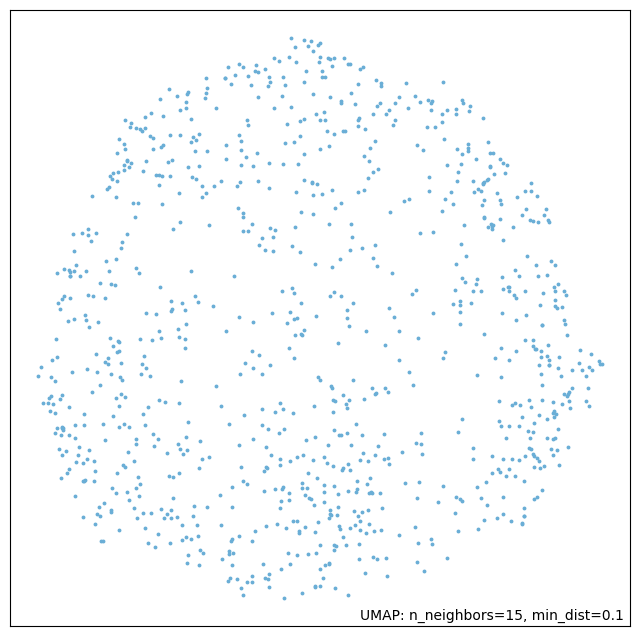

In [26]:
umap.plot.points(mapper1)

In [27]:
split_type = 'train'
hidden_train = np.load(os.path.join(dirprocess, f'audio/extract_features_{split_type}4.npy'))
hidden_train = torch.tensor(hidden_train, dtype=torch.float32)
hidden_train = einops.rearrange(hidden_train, 'b t f -> b f t')

df_train = pd.read_csv(os.path.join(dirprocess, f'dataframe/df_{split_type}27.csv'))

In [28]:
mapper_train = umap.UMAP(random_state=42).fit(hidden_train.flatten(start_dim=1).detach().cpu().numpy())

C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:\Users\Semenkov\Anaconda3\envs\MEG-AI-Master-Class\Lib\site-packages\umap\plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

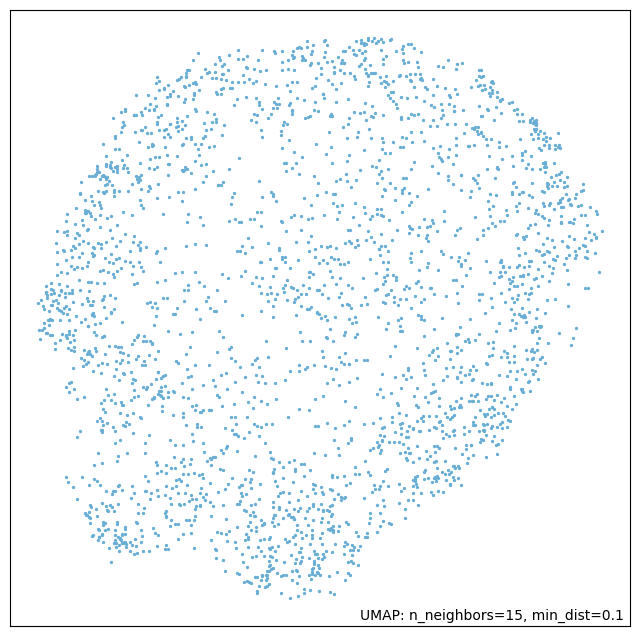

In [29]:
umap.plot.points(mapper_train)

In [30]:
from sklearn import manifold